In [1]:
%cd ..

/home/dani2442/Projects/Functional-Data-Analysis


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from fpca import FPCA, FFPCA, estimate_cov_mean, estimate_fourier_cov_mean

## 1. Load the training and testing data

In [3]:
train_df = pd.read_pickle("data/esa-adb-challenge/train.pkl")
test_df = pd.read_pickle("data/esa-adb-challenge/test.pkl")

Plot a sample of the data

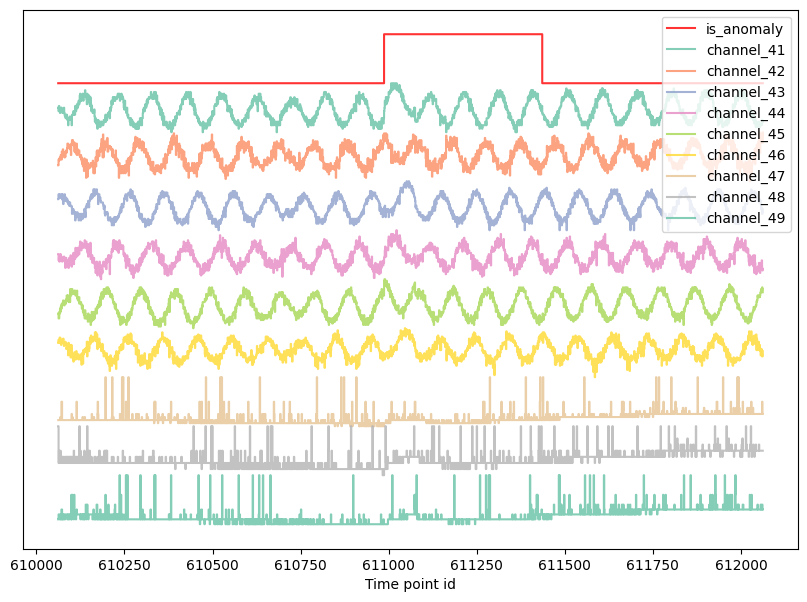

In [4]:
plt.rcParams["image.cmap"] = "Set2"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.figure(figsize=(10,7))

start_idx = 610062
end_idx = start_idx + 2000

channel_names = [f"channel_{x}" for x in range(41,50)]

plt.step(train_df.loc[start_idx:end_idx, "id"], train_df.loc[start_idx:end_idx, "is_anomaly"] + 1, alpha=0.8, label="is_anomaly", where="post", color="red")

for i, channel in enumerate(channel_names):
    d = train_df.loc[start_idx:end_idx, channel]
    d = (d - np.min(d))/(np.max(d) - np.min(d))

    plt.step(train_df.loc[start_idx:end_idx, "id"], d - i, alpha=0.8, label=channel, where="post")

plt.xlabel("Time point id")
plt.yticks([], [])
plt.legend(loc="upper right")

In [5]:
# Select the channels that contain functional data
channel_names = [f"channel_{x}" for x in [12, 13, 17, 18, 19, 20, 25, 26, 27, 28, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, ]]

x_train = train_df[channel_names]
y_train = train_df["is_anomaly"]

## 2. Preprocess and smooth the data containing noise.
We use a rolling median centered to remove the noise of the data. Next, we standarize the data, i.e., $\tilde{X}_i(t) := \frac{X_i(t)- \mu_i}{\sigma_i}$.

The preprocess takes several minutes, hence, we store the result to avoid executing it several times.

In [6]:
#x_train = x_train.rolling(15, center=True).median()
#x_train = (x_train - x_train.mean()) / x_train.std()
#x_train.to_pickle("data/esa-adb-challenge/x_train_mini.pkl")
x_train = pd.read_pickle("data/esa-adb-challenge/x_train.pkl")

In [7]:
x_train.describe()

,channel_12,channel_13,channel_17,channel_18,channel_19,channel_20,channel_25,channel_26,channel_27,channel_28,channel_34,channel_35,channel_36,channel_37,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46
count,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07
mean,4.780799e-16,-2.107578e-16,4.975316e-16,-2.904789e-16,4.777094e-16,5.904676e-16,4.328161e-16,4.155874e-16,2.787462e-16,1.461657e-16,1.207859e-16,-4.507858e-17,1.049775e-17,-5.455743e-16,1.794139e-15,-1.756621e-15,1.054966e-15,-1.213579e-15,-2.301246e-16,-1.718424e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.440644e+00,-2.466942e+00,-2.687089e+00,-2.854837e+00,-3.000815e+00,-2.558597e+00,-2.703758e+00,-2.600298e+00,-2.711986e+00,-2.610680e+00,-2.482029e+00,-2.526741e+00,-2.435397e+00,-2.531232e+00,-2.596441e+01,-2.532174e+01,-2.409692e+01,-2.297262e+01,-2.582097e+01,-2.519210e+01
25%,-8.119577e-01,-8.397835e-01,-8.229940e-01,-8.056876e-01,-7.032217e-01,-8.363390e-01,-7.896670e-01,-8.277448e-01,-8.263801e-01,-7.696650e-01,-7.865463e-01,-7.776587e-01,-7.690532e-01,-8.100531e-01,-8.749070e-02,-1.250101e-01,-6.984318e-02,-7.786586e-02,-9.170119e-02,-1.277817e-01
50%,-2.548531e-02,-1.085191e-02,-1.963393e-02,-3.945059e-02,-5.380960e-02,-2.052232e-02,-3.204938e-02,-3.643833e-02,-1.742281e-02,-4.936755e-02,-2.651628e-02,-5.392418e-02,-2.423571e-02,-2.076272e-02,3.858430e-02,5.703568e-02,5.419594e-02,5.879994e-02,4.336733e-02,3.890981e-02
75%,7.609873e-01,7.566701e-01,7.837255e-01,7.574042e-01,6.803214e-01,7.650757e-01,7.559110e-01,7.865254e-01,7.626398e-01,7.336968e-01,7.920212e-01,7.430124e-01,7.481717e-01,7.392912e-01,1.898846e-01,2.390370e-01,1.782351e-01,1.954261e-01,2.054754e-01,2.333365e-01
max,1.436484e+01,1.342468e+01,1.364143e+01,1.392036e+01,1.323072e+01,1.313990e+01,1.444751e+01,1.352502e+01,1.403664e+01,1.467350e+01,1.576411e+01,1.481844e+01,1.362517e+01,1.338001e+01,5.535204e+00,5.751925e+00,5.636033e+00,5.114890e+00,6.013817e+00,6.234048e+00


## 3. Estimate the Covariance matrix

Firstly, we need to choose a window size `N`. The covariance matrix is estimated using a batch procedure because doing a loop is expensive. The batch size is given by `bs` and the number of iterations is `n`.

We calculate both the covariance of the sample `cov` and the fourier transformation of the sample `cov_hat`, as well as the mean `mu` and `mu_hat`. Next, we store the results to avoid computing this slow procedure redundantly.

<div>
<img src="../images/sliding_window2.png" width="500"/>
</div>

In [8]:
N = 4000 # window size
bs = 256 # batch size
n = 100 # iterations

In [9]:
cov, mu = estimate_cov_mean(x_train, N, bs, n)
cov_hat, mu_hat = estimate_fourier_cov_mean(x_train, N, bs, n)

np.save("data/cov.npy", cov)
np.save("data/cov_hat.npy", cov_hat)
np.save("data/mu.npy", mu)
np.save("data/mu_hat.npy", mu_hat)

cov = np.load("data/cov.npy")
cov_hat = np.load("data/cov_hat.npy")
mu = np.load("data/mu.npy")
mu_hat = np.load("data/mu_hat.npy")

100%|██████████| 100/100 [07:06<00:00,  4.27s/it]


In [10]:
fpca1 = FPCA()
ffpca1 = FFPCA()
fpca1.set_eigenvectors(cov)
fpca1.set_mean(mu)
ffpca1.set_eigenvectors(cov_hat)
ffpca1.set_mean(mu_hat)

## 4. Calculate the reconstruction error

In [22]:
t_start = 900000
t_step = 20
t_end = 1350000
t = np.arange(t_start, t_end, t_step)
r1, r2 = np.zeros_like(t, dtype=np.float32), np.zeros_like(t, dtype=np.float32)

def error(x1, x2):
    return np.mean(np.max(np.square(x1.real - x2.real), axis=0))

In [23]:
for i, ti in tqdm(enumerate(t), total=len(t)):
    x = np.expand_dims(x_train.loc[ti-N+1:ti].to_numpy(), axis=1)
    y1 = fpca1.transform(x, 1)
    y2 = ffpca1.transform(x, 1)

    r1[i] = error(x, y1)
    r2[i] = error(x, y2)

error_df = pd.DataFrame({'fpca': r1, 'ffpca': r2}, index=t)
error_df.to_pickle("data/error_df.pkl")
error_df = pd.read_pickle("data/error_df.pkl")

100%|██████████| 22500/22500 [02:25<00:00, 154.86it/s]


[]

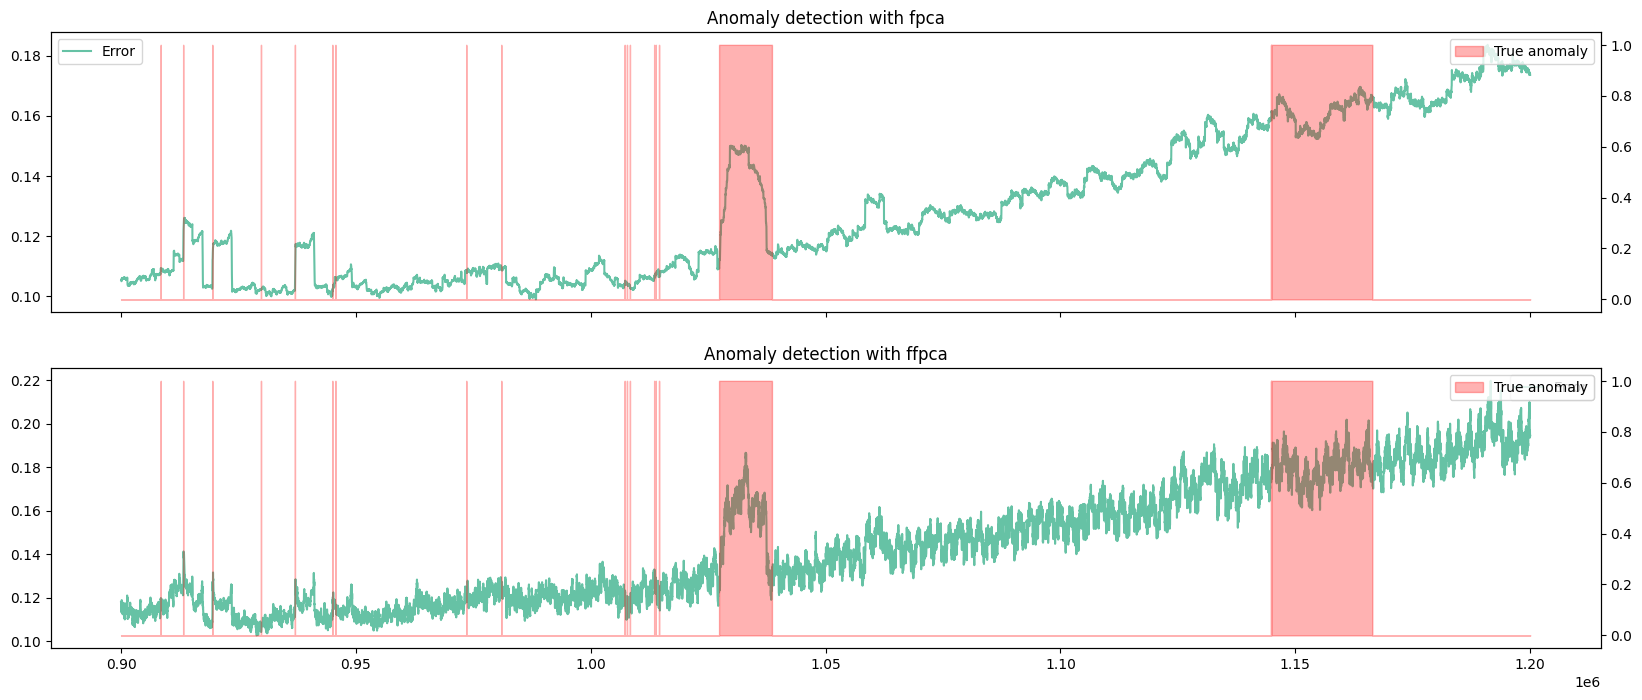

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
# Plot the Series
t1 = 900000
t2 = 1200000
y_train_loc = y_train.loc[t1:t2]
t_strip = (t >= t1) & (t <= t2)
df_error_selected = error_df.loc[(error_df.index >= t1) & (error_df.index <= t2)]

# Plot the numpy arrays
ax2 = axes[0].twinx()
ax2.fill_between(y_train_loc.index, 0, y_train_loc.values, color='red', alpha=0.3, label="True anomaly")
axes[0].plot(df_error_selected.index, df_error_selected["fpca"].values, label="Error")
#axes[0].set_ylim((0,0.2))
axes[0].set_title('Anomaly detection with fpca')
axes[0].legend()
ax2.legend()


axes[1].plot(df_error_selected.index, df_error_selected["ffpca"].values, label="Error")
ax2b = axes[1].twinx()
ax2b.fill_between(y_train_loc.index, 0, y_train_loc.values, color='red', alpha=0.3, label="True anomaly")

axes[1].set_title('Anomaly detection with ffpca')
#axes[1].set_ylim((0,0.2))
axes[1].legend()
ax2b.legend()

#axes[0].set_zorder(6)
#axes[1].set_zorder(6)
#ax2.set_zorder(5)
#ax2b.set_zorder(5)
fig.savefig("images/anomaly_detection_v3.png", dpi=300)
plt.plot()